<a href="https://colab.research.google.com/github/SeanRommes/food-sales-predictions/blob/main/food_sales_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Food-Sales Predictions**

Sean Rommes

# Imports and Data Cleaning

In [105]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn. model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config
set_config(display='diagram')
filename = '/content/drive/MyDrive/Coding Dojo Course Work/project downloads/sales_predictions.csv'

In [106]:
df = pd.read_csv(filename)
df.head(10)
# resources below
# https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [107]:
len(df)

8523

In [108]:
df.duplicated().sum()

0

In [109]:
# I'm having a hard time determining if these columns are useful for analysis 
# so i'm considering dropping these: Outlet Identifier, Outlet establishment year,
# outlet size, location type, and item weight
# may consider dropping Item weights to focus on what the item was and how well it sold but tbd
df = df.drop(columns =['Outlet_Identifier','Outlet_Establishment_Year', 'Outlet_Size','Outlet_Location_Type', 'Item_Weight'])
df.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Type,Item_Outlet_Sales
0,FDA15,Low Fat,0.016047,Dairy,249.8092,Supermarket Type1,3735.1380
1,DRC01,Regular,0.019278,Soft Drinks,48.2692,Supermarket Type2,443.4228
2,FDN15,Low Fat,0.016760,Meat,141.6180,Supermarket Type1,2097.2700
3,FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,Grocery Store,732.3800
4,NCD19,Low Fat,0.000000,Household,53.8614,Supermarket Type1,994.7052


In [110]:
# looking for missing values
df.isna().sum()

Item_Identifier      0
Item_Fat_Content     0
Item_Visibility      0
Item_Type            0
Item_MRP             0
Outlet_Type          0
Item_Outlet_Sales    0
dtype: int64

In [111]:
df.nunique()

Item_Identifier      1559
Item_Fat_Content        5
Item_Visibility      7880
Item_Type              16
Item_MRP             5938
Outlet_Type             4
Item_Outlet_Sales    3493
dtype: int64

In [112]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [113]:
# there are 5 identical values for fats so i'm going to replace these with 'Regular' or 'Low Fat'
# no high fat values strangly enough
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [114]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'].value_counts()                                               

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [115]:
# here's the cleaned data
df.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Type,Item_Outlet_Sales
0,FDA15,Low Fat,0.016047,Dairy,249.8092,Supermarket Type1,3735.1380
1,DRC01,Regular,0.019278,Soft Drinks,48.2692,Supermarket Type2,443.4228
2,FDN15,Low Fat,0.016760,Meat,141.6180,Supermarket Type1,2097.2700
3,FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,Grocery Store,732.3800
4,NCD19,Low Fat,0.000000,Household,53.8614,Supermarket Type1,994.7052


In [116]:
# I'm okay with this
df['Item_Type'].describe()

count                      8523
unique                       16
top       Fruits and Vegetables
freq                       1232
Name: Item_Type, dtype: object

In [117]:
# everything here seems to be as it should be
df.info()
print(df.isna().sum().sum(),'Missing values')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item_Identifier    8523 non-null   object 
 1   Item_Fat_Content   8523 non-null   object 
 2   Item_Visibility    8523 non-null   float64
 3   Item_Type          8523 non-null   object 
 4   Item_MRP           8523 non-null   float64
 5   Outlet_Type        8523 non-null   object 
 6   Item_Outlet_Sales  8523 non-null   float64
dtypes: float64(3), object(4)
memory usage: 466.2+ KB
0 Missing values


# Statistical Values

**Obtaining statistical values of numerical columns MRP, Visibility, Outlet types, and Outlet_Sales**

In [119]:
df['Item_MRP'].describe().round(3)

count    8523.000
mean      140.993
std        62.275
min        31.290
25%        93.826
50%       143.013
75%       185.644
max       266.888
Name: Item_MRP, dtype: float64

In [122]:
df['Item_Visibility'].describe().round(3)

count    8523.000
mean        0.066
std         0.052
min         0.000
25%         0.027
50%         0.054
75%         0.095
max         0.328
Name: Item_Visibility, dtype: float64

In [121]:
df['Outlet_Type'].describe()

count                  8523
unique                    4
top       Supermarket Type1
freq                   5577
Name: Outlet_Type, dtype: object

In [120]:
df['Item_Outlet_Sales'].describe().round(3)

count     8523.000
mean      2181.289
std       1706.500
min         33.290
25%        834.247
50%       1794.331
75%       3101.296
max      13086.965
Name: Item_Outlet_Sales, dtype: float64

# Histogram

This histogram tells us the number of samples that occur in a category. For item visibility, most products were not allocated alot of space, under MRP there were more than 1200 samples that were priced between 100 and 125, under item sales the cheapest items were sold the most

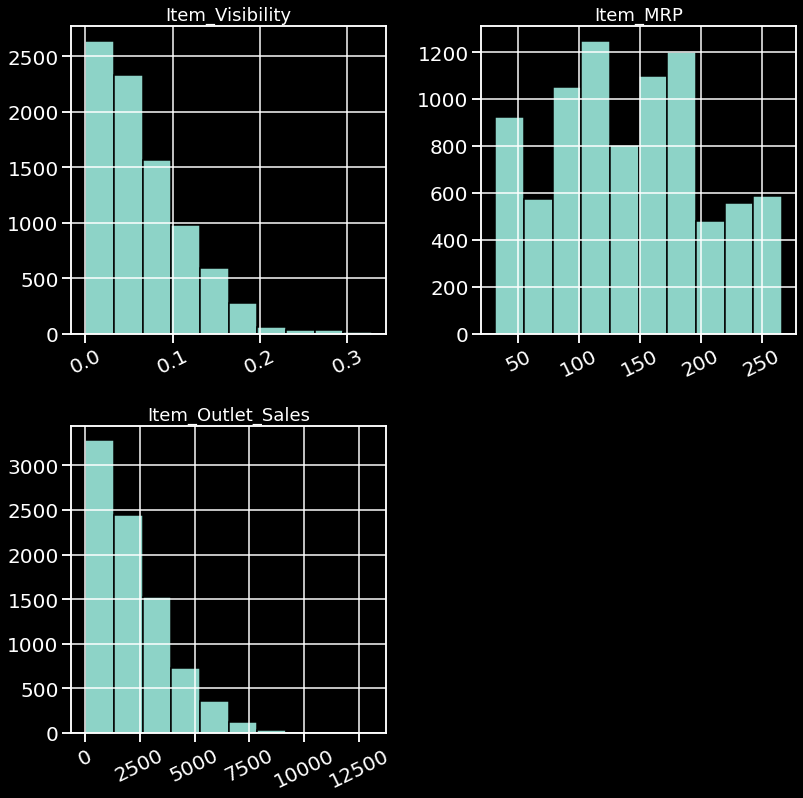

In [123]:
df.hist(edgecolor='black',
        xlabelsize=20,
        ylabelsize=20,
        grid=True,
        figsize=[13,13],
        xrot=26,);

# Box Plot

This boxplot infers that the maximum retail price, in comparison to outlet sales, is much lower. This tells us that venders are setting there prices as high as they can to make a profit(unsurprisingly). The table below the box plot gives us a closer look.

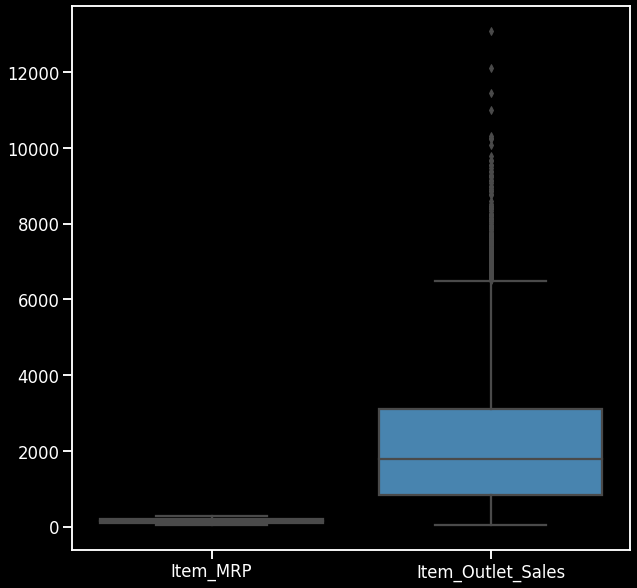

In [124]:
plt.figure(figsize= (10,10))
sns.boxplot(data = df.loc[:,['Item_MRP', 'Item_Outlet_Sales',]], palette = 'Blues');

I decided to add this down here to help us understand the box plot, since the MRP is so low in comparision to outlet sales. We can see that the min price for these goods range from 31 - 40. We can also see that the min value for MRP on say, baking goods is 33.99 and was sold for a minimum of 37.28, a 9% increase. This means that, on average, baking goods has a profit margin of 9%, excluding operational costs.

In [125]:
df.groupby(['Item_Type'])[['Item_MRP','Item_Outlet_Sales']].describe().round(2)

Item_MRP                                                \
                         count    mean    std    min     25%     50%     75%   
Item_Type                                                                      
Baking Goods             648.0  126.38  58.06  33.99   84.07  112.35  170.99   
Breads                   251.0  140.95  63.50  31.96   91.31  129.13  194.73   
Breakfast                110.0  141.79  58.46  40.05   99.86  155.36  178.31   
Canned                   649.0  139.76  60.81  36.35   89.88  140.15  184.59   
Dairy                    682.0  148.50  70.33  33.49   88.83  147.54  213.37   
Frozen Foods             856.0  138.50  67.46  31.96   83.70  128.65  190.58   
Fruits and Vegetables   1232.0  144.58  60.48  36.25   98.39  145.54  188.48   
Hard Drinks              214.0  137.08  62.02  34.25  106.32  144.94  177.68   
Health and Hygiene       520.0  130.82  59.38  33.12   95.39  128.03  163.85   
Household                910.0  149.42  62.39  32.46  107.76  153.32  191.60   
Meat                     425.0  139.88  58.12  34.75   98.30  146.57  185.26   
Others                   169.0  132.85  58.68  35.02   84.09  130.93  180.37   
Seafood                   64.0  141.84  58.62  33.72  109.21  158.56  184.71   
Snack Foods             1200.0  146.19  58.90  32.36  104.35  146.67  185.83   
Soft Drinks              445.0  131.49  60.75  31.29   82.43  144.01  176.21   
Starchy Foods            148.0  147.84  69.29  34.05   90.69  166.93  205.49   

                              Item_Outlet_Sales                            \
                          max             count     mean      std     min   
Item_Type                                                                   
Baking Goods           265.56             648.0  1952.97  1546.79   37.28   
Breads                 263.66             251.0  2204.13  1644.24   35.29   
Breakfast              234.93             110.0  2111.81  1911.69   39.95   
Canned                 266.89             649.0  2225.19  1645.24   37.95   
Dairy                  266.69             682.0  2232.54  1884.40   40.61   
Frozen Foods           264.89             856.0  2132.87  1724.78   36.62   
Fruits and Vegetables  264.23            1232.0  2289.01  1799.50   45.27   
Hard Drinks            261.43             214.0  2139.22  1606.19   37.95   
Health and Hygiene     266.69             520.0  2010.00  1553.63   34.62   
Household              264.79             910.0  2258.78  1692.25   33.29   
Meat                   261.59             425.0  2158.98  1695.23   47.94   
Others                 254.90             169.0  1926.14  1431.86   39.95   
Seafood                240.29              64.0  2326.07  1842.99  149.80   
Snack Foods            264.96            1200.0  2277.32  1705.12   33.96   
Soft Drinks            263.59             445.0  2006.51  1674.25   33.29   
Starchy Foods          263.03             148.0  2374.33  1773.95   58.59   

                                                           
                          25%      50%      75%       max  
Item_Type                                                  
Baking Goods           705.08  1577.95  2823.82   7931.68  
Breads                 968.74  1860.25  3145.90   8958.34  
Breakfast              679.12  1554.64  2970.30   8209.31  
Canned                 952.09  1860.25  3101.30  10306.58  
Dairy                  788.97  1650.85  3296.21  10256.65  
Frozen Foods           808.95  1687.14  3079.49   9678.07  
Fruits and Vegetables  884.85  1830.95  3227.13  12117.56  
Hard Drinks            834.91  1816.64  3071.34   7843.12  
Health and Hygiene     758.85  1669.49  2884.58   9779.94  
Household              853.39  1981.42  3236.79  13086.96  
Meat                   782.98  1829.62  3036.05   9390.44  
Others                 790.97  1713.77  2719.79   6008.84  
Seafood                473.38  2055.32  3589.33   6503.53  
Snack Foods            918.80  1944.14  3143.57  10993.69  
Soft Drinks      

# Heat Map

 MRP and sales have a weak correlation to item visibility, this heatmap suggests that just because an item is allocated a larger area it does not mean it will sell well

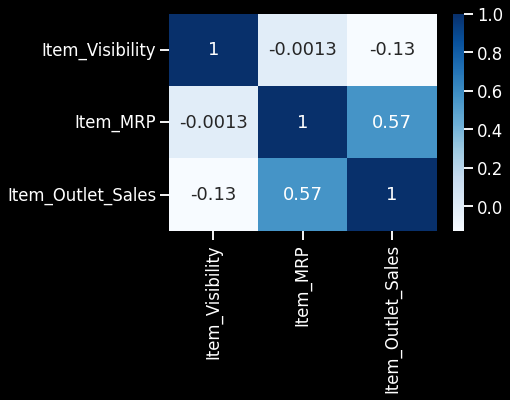

In [126]:
corr = df.corr()
sns.heatmap(corr,cmap = 'Blues',annot = True,);

# Line Graphs

These line graphs tell us which products and outlet types had the most sales, which goods were the most popular, and also which outlet types sold the most products. The background hue is the predictive margin of the line, based off the min and max values.Starchy foods had the highest sales of all outlet types, this is kind of broad as that could include things like rice, potatoes, pastas, or noodles. Snack foods, Breads, Seafoods, and Canned goods are also top sellers. Two tables support that type 3 supermarkets conduct the most sales. The data dictionary is unclear as to what type of supermarket this is. Bulk sellers like Costco or Samsclub? Walmart? ToysRus? I really wish I could be more specific

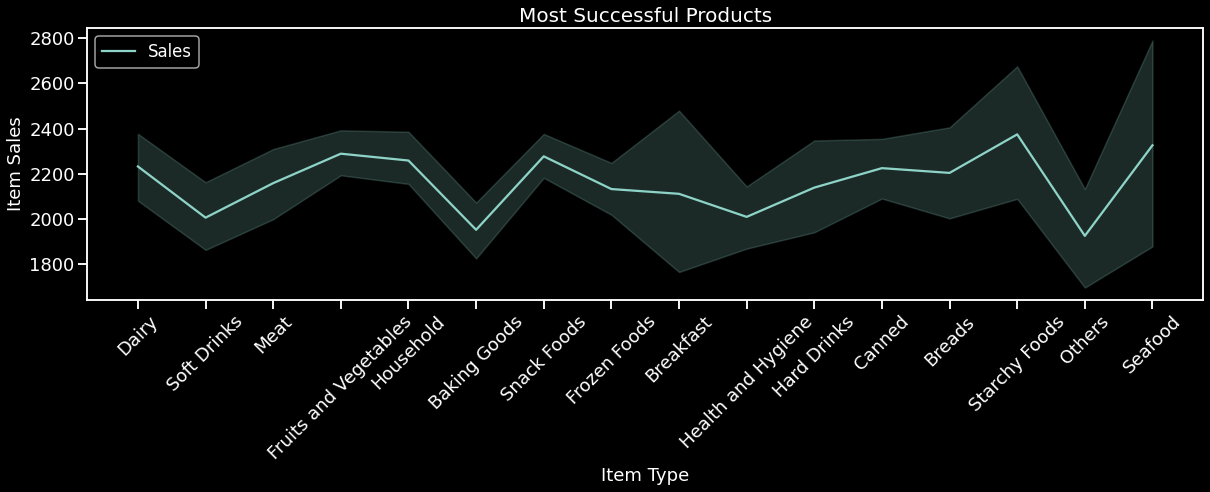

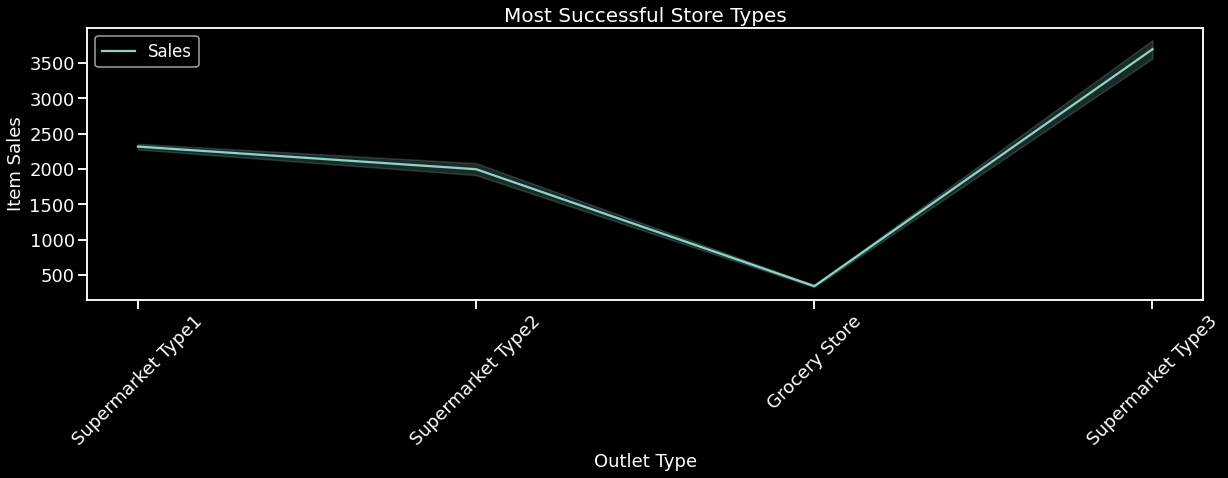

In [140]:
sns.set_context('talk')
plt.style.use('dark_background')
plt.figure(figsize= (20,5));
sns.lineplot(x = 'Item_Type', y = 'Item_Outlet_Sales', data = df, markers = ['S'],
             label = f'Sales');
plt.xlabel('Item Type',fontsize = 18)
plt.ylabel('Item Sales',fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(rotation = 45, fontsize = 18);
plt.title('Most Successful Products', fontsize = 20)
plt.legend(loc = 'upper left')

plt.figure(figsize= (20,5));
sns.lineplot(x = 'Outlet_Type', y = 'Item_Outlet_Sales', data = df, markers = ['S'],
             label = f'Sales');
plt.xticks(rotation = 45);
plt.xlabel('Outlet Type',fontsize = 18)
plt.ylabel('Item Sales',fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(rotation = 45, fontsize = 18);
plt.title('Most Successful Store Types', fontsize = 20)
plt.legend();

In [138]:
print('These are our max values')
df.groupby(['Item_Type'])[['Outlet_Type']].max()

These are our max values


,Outlet_Type
Item_Type,
Baking Goods,Supermarket Type3
Breads,Supermarket Type3
Breakfast,Supermarket Type3
Canned,Supermarket Type3
Dairy,Supermarket Type3
Frozen Foods,Supermarket Type3
Fruits and Vegetables,Supermarket Type3
Hard Drinks,Supermarket Type3
Health and Hygiene,Supermarket Type3


# Machine Learning Instantiation

The goal of this step is to help the retailer by using machine learning to make predictions about future sales based on the data provided.

In this phase I'll identify the features (X) and target (y), assigning the "Item_Outlet_Sales" column as the target and the rest of the relevant variables as the features matrix. Then I'll perform the train test split, and create a preprocessing object to prepare the dataset for machine learning.

In [129]:
X = df.drop(columns = ['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']
    
X_train, X_test, y_train,y_test= train_test_split(X,y,random_state=42)

In [128]:
df.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Type,Item_Outlet_Sales
0,FDA15,Low Fat,0.016047,Dairy,249.8092,Supermarket Type1,3735.1380
1,DRC01,Regular,0.019278,Soft Drinks,48.2692,Supermarket Type2,443.4228
2,FDN15,Low Fat,0.016760,Meat,141.6180,Supermarket Type1,2097.2700
3,FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,Grocery Store,732.3800
4,NCD19,Low Fat,0.000000,Household,53.8614,Supermarket Type1,994.7052


In [130]:
# instantiating column selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

# onehot encoding and scaling
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)

# instantiating pipeline
num_pipeline = make_pipeline(scaler)
cat_pipeline = make_pipeline(ohe)

# instantiating column transfer
num_tuple = (num_pipeline,num_sel)
cat_tuple = (cat_pipeline,cat_sel)

#containing within a single preprocessing object
preprocessor = make_column_transformer(num_tuple,cat_tuple)

# fitting pipeline
preprocessor.fit(X_train)

# transforming training/testing data to display the np array
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_processed.round(0)

array([[-1.,  2.,  0., ...,  0.,  1.,  0.],
       [-1.,  1.,  0., ...,  0.,  1.,  0.],
       [ 2.,  0.,  0., ...,  1.,  0.,  0.],
       ...,
       [-1.,  2.,  0., ...,  1.,  0.,  0.],
       [-0., -0.,  0., ...,  1.,  0.,  0.],
       [-1., -1.,  0., ...,  1.,  0.,  0.]])

In [145]:
# converting to pandas df
X_train_processed= pd.DataFrame(X_train_processed)
X_train_processed

,0,1,2,3,4,5,6,7,8,9,...,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573
0,-0.712775,1.828109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.291052,0.603369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.813319,0.244541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.004931,-0.952591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.965484,-0.336460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4.309657,-0.044657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6388,1.008625,-1.058907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6389,-0.920527,1.523027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6390,-0.227755,-0.383777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Linear Regression Model

In [142]:
# Instantiating linear regression
lin_reg = LinearRegression()

# Instantiating pipelines
linline = make_pipeline(preprocessor,lin_reg)

#fitting
linline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f72bb2306d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f72bb230650>)])),
                ('linearregression', LinearRegression())])

In [132]:
# making predictions for the linear model

train_pred = linline.predict(X_train)
test_pred = linline.predict(X_test)
lin_r2_train = np.corrcoef(y_train, train_pred)
lin_r2_test = np.corrcoef(y_test, test_pred)

In [133]:
# evaluating predictions using R2

train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f'Model Training R Squared:{round(r2_score(y_train,train_pred),3)}')
print(f'Model Testing R Squared: {round(r2_score(y_test,test_pred),3)}')

Model Training R Squared:0.671
Model Testing R Squared: -1.0216500976399734e+22


This model performed poorly on the testing metric yet it was still able to predict 67% of the data in training.  The negative in the testing score indicates a problem with the testing data

In [134]:
# Getting RMSE for train vs test
rmse_train =  mean_squared_error(y_train, train_pred, squared = False)
rmse_test = mean_squared_error(y_test, test_pred, squared= False)
print(f"Train RMSE: { round(rmse_train, 2)}")
print(f"Test RMSE: { round( rmse_test, 2)}")

Train RMSE: 987.04
Test RMSE: 167890125244879.66


Train rmse is low, which means there aren't any serious high end errors, which could indicate underfitting as testing values are
outrageous

# Random Forest Model

In [146]:
#planting random forest

rf = RandomForestRegressor(random_state=42)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [147]:
# making random forest pipeline

rf_pipe = make_pipeline(preprocessor,rf)

In [148]:
#training Random Forest

rf_pipe.fit(X_train,y_train)

# Predicting Random Forest
rf_pipe.predict(X_test)

array([ 833.48173 , 1013.940162,  937.71272 , ..., 5003.72003 ,
       1950.307966, 1894.374108])

In [150]:
rftrain_preds = rf_pipe.predict(X_train)
rftest_preds = rf_pipe.predict(X_test)

In [154]:
# evaluating predictions using R2

rftrain_r2 = r2_score(y_train, rftrain_preds)
rftest_r2 = r2_score(y_test, rftest_preds)

print(f'Model Training R Squared:{round(r2_score(y_train,rftrain_preds),3)}')
print(f'Model Testing R Squared: {round(r2_score(y_test,rftest_preds),3)}')

Model Training R Squared:0.934
Model Testing R Squared: 0.512


Our random forest performed better on the train data but is still over fitted to the testing data, I'll have to tune the hyper paramaters to get better results. In the mean time it can predict 93% of our training data, which is great.

In [151]:
## Get RMSE for train vs test
rf_train =  mean_squared_error(y_train, train_pred, squared = False)
rf_test = mean_squared_error(y_test, test_pred, squared= False)
print(f"Train RMSE: { round(rf_train, 2)}")
print(f"Test RMSE: { round( rf_test, 2)}")

Train RMSE: 987.04
Test RMSE: 167890125244879.66


We got a similar score as our linear model, again I believe the model is over fitted for our testing data

## Recommendations

I would recomend our random forest model as it performed better on the r2 score with no tuning compared to our linear model which was also un-tuned. Our random forest was able to predict 93% of the training data, and, after some adjustments, i'm confident it can perform even better after some tuning!